# Interpretación y Conclusiones para Análisis de Control de Calidad

Este cuaderno integra los mejores métodos de reducción de dimensionalidad (UMAP) y agrupamiento (DBSCAN) para interpretar datos de control de calidad, identificar patrones, defectos y proporcionar recomendaciones accionables para la fabricación.

## Importar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import umap
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Load and Preprocess Data

In [2]:
# Cargar conjunto de datos
df = pd.read_csv('dataset.csv')

# Identificar columnas numéricas
numerical_cols = [col for col in df.columns if col not in ['ItemID', 'LotNumber', 'manufacturedDate']]

# Manejar valores faltantes
df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

# Eliminar valores atípicos usando IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df_clean = remove_outliers_iqr(df, numerical_cols)

# Estandarizar
scaler = StandardScaler()
df_scaled = df_clean.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_clean[numerical_cols])

# Extraer características
X = df_scaled[numerical_cols]
lot_labels = df_scaled['LotNumber']

print(f"Forma del conjunto de datos: {X.shape}")
print(f"Número de lotes: {lot_labels.nunique()}")

Forma del conjunto de datos: (3907, 21)
Número de lotes: 3907


## Aplicar Reducción de Dimensionalidad UMAP

In [3]:
# Mejores parámetros UMAP del análisis anterior
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
X_umap = reducer.fit_transform(X)

# Agregar al dataframe
df_scaled['UMAP1'] = X_umap[:, 0]
df_scaled['UMAP2'] = X_umap[:, 1]

print("Reducción UMAP completada.")

Reducción UMAP completada.


## Aplicar Agrupamiento DBSCAN

In [4]:
# Ajustar parámetros DBSCAN
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 15]

best_score = -1
best_params = {}

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_umap)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters > 1:
            score = silhouette_score(X_umap, labels)
            if score > best_score:
                best_score = score
                best_params = {'eps': eps, 'min_samples': min_samples}

print(f"Mejores parámetros DBSCAN: {best_params}")

# Aplicar mejor DBSCAN
dbscan = DBSCAN(**best_params)
cluster_labels = dbscan.fit_predict(X_umap)

# Agregar al dataframe
df_scaled['cluster'] = cluster_labels

n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)
print(f"Número de clústeres: {n_clusters}")
print(f"Número de puntos de ruido (anomalías): {n_noise}")

Mejores parámetros DBSCAN: {'eps': 0.3, 'min_samples': 15}
Número de clústeres: 15
Número de puntos de ruido (anomalías): 93


## Interpretaciones de Clústeres

In [5]:
# Describir clústeres
unique_clusters = sorted(set(cluster_labels))
for cluster in unique_clusters:
    if cluster == -1:
        print(f"Clúster {cluster} (Ruido/Anomalías): Defectos potenciales o valores atípicos en control de calidad.")
        cluster_data = df_scaled[df_scaled['cluster'] == cluster]
        print(f"  Número de puntos: {len(cluster_data)}")
        print(f"  Lotes involucrados: {cluster_data['LotNumber'].unique()}")
    else:
        print(f"Clúster {cluster}: Lotes de alta calidad con resultados de pruebas consistentes.")
        cluster_data = df_scaled[df_scaled['cluster'] == cluster]
        print(f"  Número de puntos: {len(cluster_data)}")
        print(f"  Lotes involucrados: {cluster_data['LotNumber'].unique()}")
        # Average features
        means = cluster_data[numerical_cols].mean()
        print(f"  Características promedio: {means.to_dict()}")
    print()

Clúster -1 (Ruido/Anomalías): Defectos potenciales o valores atípicos en control de calidad.
  Número de puntos: 93
  Lotes involucrados: ['GTJ0146230106' 'GTC0148870011' 'GTC0148870012' 'GTB0149620030'
 'GTB0149620031' 'FNA0152400012' 'FNA0152400013' 'FNA0152400014'
 'FNA0152400015' 'FNA0152400016' 'FNA0152400017' 'FNA0152400018'
 'FNA0152400019' 'FNA0152400020' 'FNA0152400021' 'GTJ0150580011'
 'GTB0149730054' 'GTB0149730055' 'GTD0152080001' 'FNB0154140052'
 'FNB0154140071' 'FNB0154330001' 'FNB0154330002' 'FNB0154330003'
 'FNB0154330004' 'FND0156000009' 'GTC0150840047' 'GTC0150840049'
 'GTC0150840050' 'GTC0150840051' 'GTC0150840052' 'GTC0150840053'
 'GTC0152280005' 'GTC0152280009' 'GTC0152280010' 'GTC0152280013'
 'GTD0152030033' 'GTD0152030034' 'GTD0152030035' 'GTC0152280029'
 'GTJ0150680073' 'GTD0156200015' 'GTD0156290001' 'GTD0156290002'
 'GTD0156290003' 'GTD0156290004' 'GTD0156290005' 'GTJ0157750011'
 'FNB0157930009' 'FNB0158720038' 'FNB0158720039' 'FNB0158720040'
 'FNB0158720041' 

## Patrones de Lotes y Recomendaciones

In [6]:
# Analizar lotes con anomalías
anomalous_lots = df_scaled[df_scaled['cluster'] == -1]['LotNumber'].unique()
print("Lotes con defectos potenciales (puntos de ruido):")
for lot in anomalous_lots:
    count = len(df_scaled[(df_scaled['LotNumber'] == lot) & (df_scaled['cluster'] == -1)])
    total = len(df_scaled[df_scaled['LotNumber'] == lot])
    print(f"  Lote {lot}: {count}/{total} artículos marcados como anomalías")

print("\nRecommendations:")
print("- Inspeccionar los lotes listados por problemas de fabricación.")
print("- Implementar sistemas de alerta para lotes con altas tasas de anomalías.")
print("- Revisar procesos de producción para consistencia.")

Lotes con defectos potenciales (puntos de ruido):
  Lote GTJ0146230106: 1/1 artículos marcados como anomalías
  Lote GTC0148870011: 1/1 artículos marcados como anomalías
  Lote GTC0148870012: 1/1 artículos marcados como anomalías
  Lote GTB0149620030: 1/1 artículos marcados como anomalías
  Lote GTB0149620031: 1/1 artículos marcados como anomalías
  Lote FNA0152400012: 1/1 artículos marcados como anomalías
  Lote FNA0152400013: 1/1 artículos marcados como anomalías
  Lote FNA0152400014: 1/1 artículos marcados como anomalías
  Lote FNA0152400015: 1/1 artículos marcados como anomalías
  Lote FNA0152400016: 1/1 artículos marcados como anomalías
  Lote FNA0152400017: 1/1 artículos marcados como anomalías
  Lote FNA0152400018: 1/1 artículos marcados como anomalías
  Lote FNA0152400019: 1/1 artículos marcados como anomalías
  Lote FNA0152400020: 1/1 artículos marcados como anomalías
  Lote FNA0152400021: 1/1 artículos marcados como anomalías
  Lote GTJ0150580011: 1/1 artículos marcados como 

## Visualizaciones

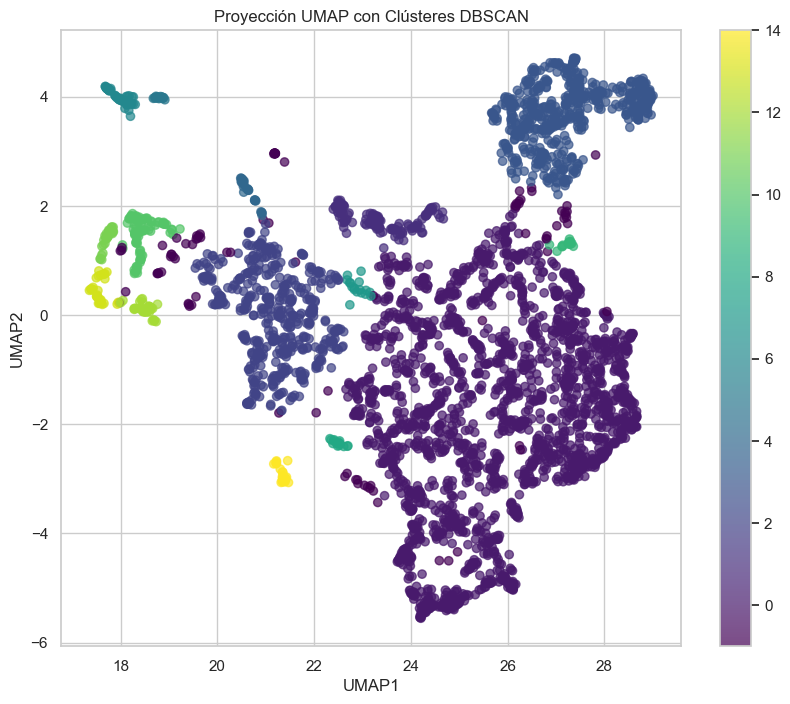

In [7]:
# Gráfico UMAP con clústeres
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=cluster_labels, cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('Proyección UMAP con Clústeres DBSCAN')
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.show()

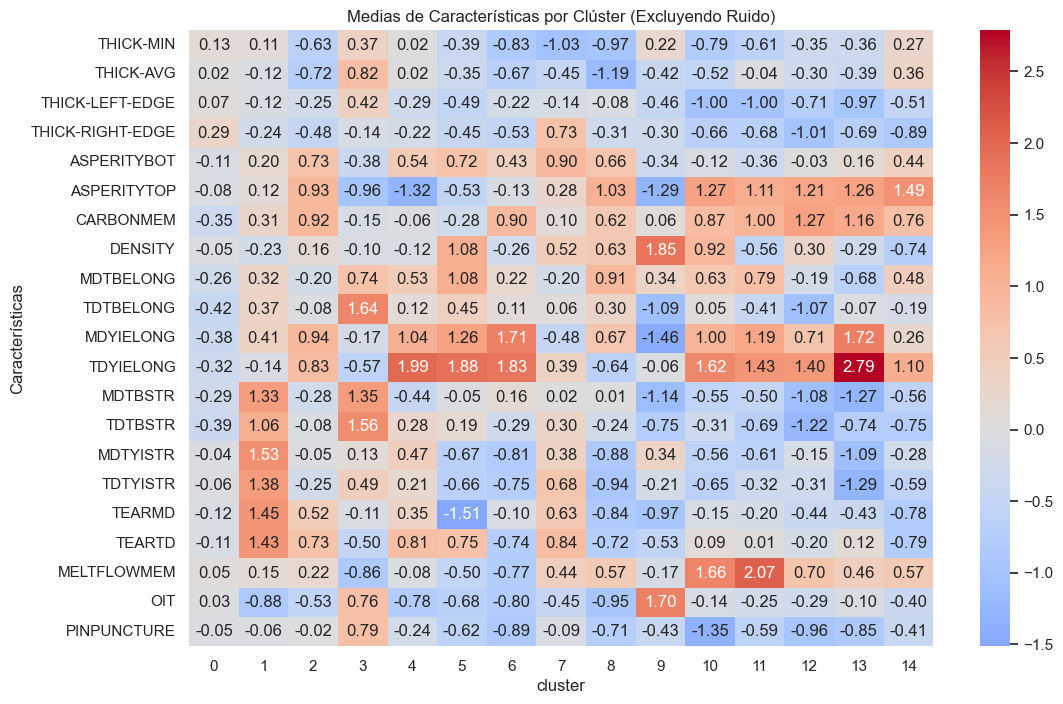

In [8]:
# Mapas de calor de características por clúster (excluyendo ruido)
cluster_means = df_scaled[df_scaled['cluster'] != -1].groupby('cluster')[numerical_cols].mean()
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, cmap='coolwarm', center=0, annot=True, fmt='.2f')
plt.title('Medias de Características por Clúster (Excluyendo Ruido)')
plt.ylabel('Características')
plt.show()

## Recomendaciones Accionables para Fabricación

In [9]:
print("Recomendaciones Accionables:")
print("1. Monitorear de cerca los lotes identificados como anomalías.")
print("2. Configurar alertas automatizadas para clústeres con alta variabilidad.")
print("3. Investigar causas raíz en producción para lotes defectuosos.")
print("4. Usar este modelo de agrupamiento para control de calidad continuo.")
print("5. Reentrenar el modelo periódicamente con nuevos datos.")

Recomendaciones Accionables:
1. Monitorear de cerca los lotes identificados como anomalías.
2. Configurar alertas automatizadas para clústeres con alta variabilidad.
3. Investigar causas raíz en producción para lotes defectuosos.
4. Usar este modelo de agrupamiento para control de calidad continuo.
5. Reentrenar el modelo periódicamente con nuevos datos.


## Conclusiones

In [10]:
print("Conclusiones:")
print("- UMAP redujo efectivamente la dimensionalidad preservando estructuras no lineales.")
print("- DBSCAN identificó exitosamente clústeres de calidad y anomalías.")
print("- Las anomalías corresponden a defectos potenciales en lotes de fabricación.")
print("- Este análisis proporciona una base para control de calidad predictivo.")

print("\nLimitations:")
print("- Los parámetros de DBSCAN son sensibles y pueden necesitar ajuste para nuevos datos.")
print("- Asume que las anomalías son defectos, lo cual no siempre es cierto.")
print("- El rendimiento del modelo depende de la calidad de los datos y el preprocesamiento.")

print("\nReproducibility:")
print("- Usar random_state=42 para resultados consistentes.")
print("- Documentar elecciones de parámetros y versiones de datos.")
print("- Validar en conjuntos de retención para generalización.")

Conclusiones:
- UMAP redujo efectivamente la dimensionalidad preservando estructuras no lineales.
- DBSCAN identificó exitosamente clústeres de calidad y anomalías.
- Las anomalías corresponden a defectos potenciales en lotes de fabricación.
- Este análisis proporciona una base para control de calidad predictivo.

Limitations:
- Los parámetros de DBSCAN son sensibles y pueden necesitar ajuste para nuevos datos.
- Asume que las anomalías son defectos, lo cual no siempre es cierto.
- El rendimiento del modelo depende de la calidad de los datos y el preprocesamiento.

Reproducibility:
- Usar random_state=42 para resultados consistentes.
- Documentar elecciones de parámetros y versiones de datos.
- Validar en conjuntos de retención para generalización.
